In [13]:
import math 
import numpy as np
import matplotlib.pyplot as plt
from micrograd.engine import Value
from graphviz import Digraph
import torch
import random

In [14]:
class Value: 

    def __init__(self, data, _children=(), _op='',label=''):
        self.data = data 
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__ (self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward(): #diff
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__ (self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad #chainrule
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
            assert isinstance(other, (int, float)), "only supporting int/float powers for now"
            out = Value(self.data**other, (self,), f'**{other}')
            def _backward():
                self.grad += (other * self.data**(other-1)) * out.grad
            out._backward = _backward
            return out

    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self,other):
        return self * other**-1
    
    def tanh(self): #just need to know how the diff works for each step
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)  # tanh
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)

    def backward(self): 
        # backpropagation with topological graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited: 
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed (topo): 
            node._backward()

In [15]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

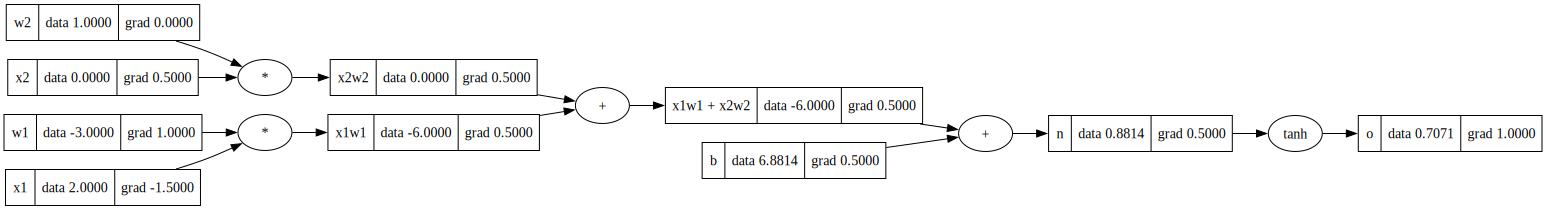

In [16]:
# imputs x1,x2
x1  = Value(2.0, label= 'x1')
x2  = Value(0.0, label= 'x2')
# weights w1,w2
w1  = Value(-3.0, label= 'w1')
w2  = Value(1.0, label= 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label ='b')
# funktions
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
# backpropagation with topological graph
o.backward()

draw_dot(o)

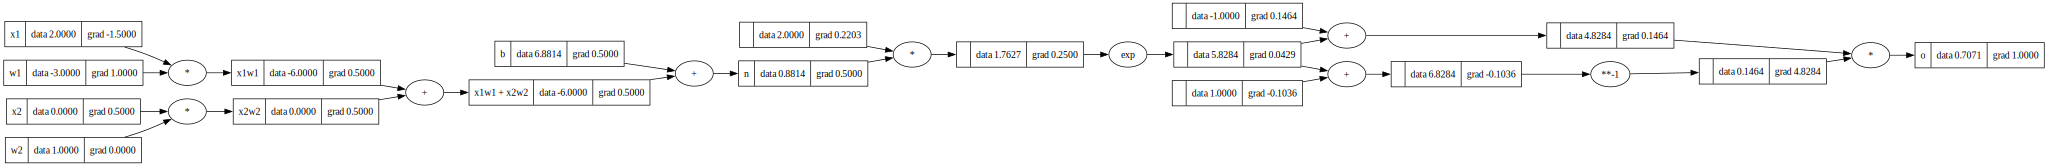

In [29]:
# imputs x1,x2
x1  = Value(2.0, label= 'x1')
x2  = Value(0.0, label= 'x2')
# weights w1,w2
w1  = Value(-3.0, label= 'w1')
w2  = Value(1.0, label= 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label ='b')
# funktions
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e-1)/(e+1); o.label = 'o' #tanh in complex
# backpropagation with topological graph
o.backward()

draw_dot(o)